# 7 Visualise activity in a video.

We have extracted all the features we plan to use. Overlaying these on the video was useful.
But watching annotated videos is inefficient and not always informative.. 

To help with understanding we build a few tools that let's see at a glance what happens over time.

# 7.1  TODO Plot movement over time. 

In each frame let's find the `centre of gravity` for each person (the average of all the high-confidence marker points). This is handy for time series visualisation. For example plotting the cog.x for each person over time shows how they move closer and further from each other. 



In [1]:
import os
import utils
import calcs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
videos_in = r"..\LookitLaughter.test"
data_out = r"..\data\1_interim"
videos_out = r"..\data\2_final"

#a couple of files for testing
VIDEO_FILE  = os.path.join(videos_in, "2UWdXP.joke1.rep2.take1.Peekaboo.mp4")
VIDEO_FILE2 = os.path.join(videos_in, "2UWdXP.joke2.rep1.take1.NomNomNom.mp4")
AUDIO_FILE = os.path.join(data_out, "2UWdXP.joke1.rep2.take1.Peekaboo.wav")
SPEECH_FILE = os.path.join(data_out, "2UWdXP.joke1.rep2.take1.Peekaboo.json")

testset = [VIDEO_FILE, VIDEO_FILE2] 

processedvideos = utils.getprocessedvideos(data_out)
processedvideos.head()

Found existing processedvideos.xlsx


,VideoID,ChildID,JokeType,JokeNum,JokeRep,JokeTake,HowFunny,LaughYesNo,Frames,FPS,...,Audio.file,Faces.when,Faces.file,LastError,Speech.file,Speech.when,Objects.file,Objects.when,Understand.file,Understand.when
0,2UWdXP.joke1.rep2.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,2,1,Slightly funny,No,217,14.298910,...,..\data\1_interim\\2UWdXP.joke1.rep2.take1.Pee...,2023-10-09 13:24:54,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,NaN,..\data\1_interim\2UWdXP.joke1.rep2.take1.Peek...,2023-09-20 16:58:38,NaN,NaN,NaN,NaN
1,2UWdXP.joke1.rep3.take1.Peekaboo.mp4,2UWdXP,Peekaboo,1,3,1,Slightly funny,No,152,14.359089,...,..\data\1_interim\\2UWdXP.joke1.rep3.take1.Pee...,2023-10-09 13:39:17,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,NaN,..\data\1_interim\2UWdXP.joke1.rep3.take1.Peek...,2023-09-20 16:58:39,NaN,NaN,NaN,NaN
2,2UWdXP.joke2.rep1.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,1,1,Funny,No,95,13.241315,...,..\data\1_interim\\2UWdXP.joke2.rep1.take1.Nom...,2023-10-09 13:40:52,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep1.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN
3,2UWdXP.joke2.rep2.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,2,1,Slightly funny,No,97,14.213813,...,..\data\1_interim\\2UWdXP.joke2.rep2.take1.Nom...,2023-10-09 13:42:05,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep2.take1.NomN...,2023-09-20 16:58:40,NaN,NaN,NaN,NaN
4,2UWdXP.joke2.rep3.take1.NomNomNom.mp4,2UWdXP,NomNomNom,2,3,1,Slightly funny,No,133,14.223092,...,..\data\1_interim\\2UWdXP.joke2.rep3.take1.Nom...,2023-10-09 13:44:38,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,NaN,..\data\1_interim\2UWdXP.joke2.rep3.take1.NomN...,2023-09-20 16:58:48,NaN,NaN,NaN,NaN


5.0 6.0


In [4]:
keypoints = utils.readKeyPointsFromCSV(processedvideos,VIDEO_FILE)


In [7]:
#this bit of pandas magic calculates average x and y for all the rows.

keypoints[["cogx","cogy"]] = keypoints.apply(lambda row: calcs.rowcogs(row.iloc[8:59]), axis=1, result_type='expand')

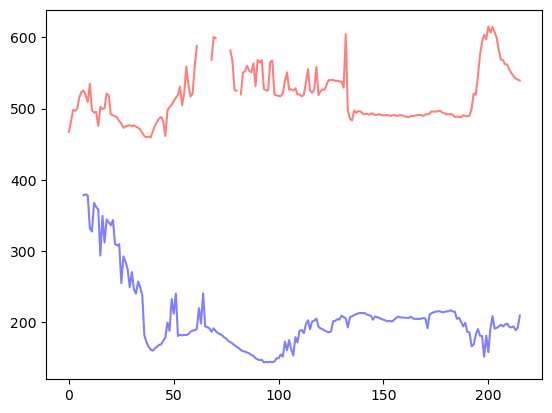

In [10]:
child = keypoints[keypoints["person"]=="child"]
adult = keypoints[keypoints["person"]=="adult"]

#a plot of child's centre of gravity frame by frame
childplot = plt.plot(child["frame"], child["cogx"], c="red", alpha=0.5)
## add line of adult's centre of gravity
adultplot = plt.plot(adult["frame"], adult["cogx"], c="blue", alpha=0.5)

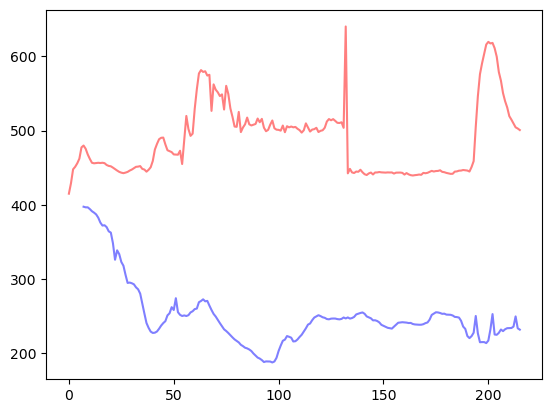

: 

In [11]:
#out of curiousity, let's plot the location of the adult and child's nose

childnoseplot = plt.plot(child["frame"], child["nose.x"], c="red", alpha=0.5)
adultnoseplot = plt.plot(adult["frame"], adult["nose.x"], c="blue", alpha=0.5)